# ViT and MLP Singular Evolutions

In [ ]:
!pip install scikit-rmt

In [ ]:
import os
import math
import random
import pickle
import tiktoken
from datetime import datetime
import inspect
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution, TracyWidomDistribution
import requests

In [ ]:
# ------------------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------------------
MODEL_TYPE = 'nanogpt'  # Choose 'mlp', 'vit', or 'nanogpt'
NUM_RUNS            = 5
NUM_EPOCHS          = 10
BATCH_SIZE          = 16
LEARNING_RATE       = 1e-2
MOMENTUM            = 0.9
LOG_EVERY_N_BATCHES = 200

INPUT_SIZE       = 28 * 28
HIDDEN_SIZE      = 1024
OUTPUT_SIZE      = 10
NUM_HIDDEN_LAYERS = 2

DATA_ROOT = './data'

# ViT configuration parameters
VIT_IMAGE_SIZE = 28
VIT_PATCH_SIZE = 7
VIT_EMBED_DIM = 64
VIT_DEPTH = 2
VIT_NUM_HEADS = 4
VIT_MLP_RATIO = 2.0
VIT_INPUT_CHANNELS = 1
VIT_INIT_FC = True

# nanoGPT configuration parameters
NANOGPT_VOCAB_SIZE = 50304  # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64
NANOGPT_BLOCK_SIZE = 128
NANOGPT_N_LAYER = 2
NANOGPT_N_HEAD = 2
NANOGPT_N_EMBD = 128
NANOGPT_DROPOUT = 0.0
NANOGPT_BIAS = False
NANOGPT_WEIGHT_DECAY = 0.1
NANOGPT_MAX_ITERS = 2000
NANOGPT_WARMUP_ITERS = 200
NANOGPT_LR_DECAY_ITERS = 2000
NANOGPT_MIN_LR = 5e-5
NANOGPT_DECAY_LR = True
NANOGPT_GRAD_CLIP = 1.0

In [ ]:
# ------------------------------------------------------------------------------
# TEXT DATA PREPARATION
# ------------------------------------------------------------------------------
enc = tiktoken.get_encoding("gpt2")

def download_text_sample(data_dir):
    """Download a sample text dataset"""
    os.makedirs(data_dir, exist_ok=True)

    # Use a tiny Shakespeare dataset instead - it's reliable and small
    sample_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    output_file = os.path.join(data_dir, "shakespeare.txt")

    if not os.path.exists(output_file):
        print(f"Downloading Shakespeare sample to {output_file}...")
        with requests.get(sample_url, stream=True) as r:
            r.raise_for_status()  # Ensure we catch HTTP errors
            total_size_in_bytes = int(r.headers.get('content-length', 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(output_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    progress_bar.update(len(chunk))
                    f.write(chunk)
            progress_bar.close()
        print(f"Download complete: {output_file}")
    else:
        print(f"File already exists: {output_file}")

    return output_file

def prepare_text_data(data_dir, val_split=0.1, seed=42):
    """Prepare text dataset for nanoGPT by tokenizing and converting to .bin files"""
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Create output directory
    os.makedirs(data_dir, exist_ok=True)

    # Download the text sample
    text_file = download_text_sample(data_dir)

    # Verify the file exists and has content
    if not os.path.exists(text_file):
        raise FileNotFoundError(f"Text file not found: {text_file}")

    if os.path.getsize(text_file) == 0:
        raise ValueError(f"Downloaded file is empty: {text_file}")

    # Read the text file and split into documents
    print("Processing text data...")
    with open(text_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # For Shakespeare, split by newlines to get reasonable chunks
    raw_documents = [doc.strip() for doc in text.split('\n') if doc.strip()]

    # Combine short lines to form more substantial documents
    documents = []
    current_doc = []
    for line in raw_documents:
        current_doc.append(line)
        # If we've accumulated about 100 tokens or hit a scene break, create a document
        if len(' '.join(current_doc)) > 400 or line.strip() == '':
            if current_doc:  # Ensure we don't add empty documents
                documents.append(' '.join(current_doc))
                current_doc = []

    # Add any remaining lines
    if current_doc:
        documents.append(' '.join(current_doc))

    print(f"Split text into {len(documents)} documents")

    # Shuffle the documents
    random.shuffle(documents)

    # Split into train/val
    n_val = max(1, int(len(documents) * val_split))
    train_documents = documents[:-n_val]
    val_documents = documents[-n_val:]

    # Tokenize
    print(f"Tokenizing {len(train_documents)} train documents...")
    train_tokens = []
    for doc in tqdm(train_documents):
        train_tokens.extend(enc.encode(doc))
        # Add a separator token (newline)
        train_tokens.append(enc.eot_token)  # EOT token

    print(f"Tokenizing {len(val_documents)} validation documents...")
    val_tokens = []
    for doc in tqdm(val_documents):
        val_tokens.extend(enc.encode(doc))
        # Add a separator token (newline)
        val_tokens.append(enc.eot_token)  # EOT token

    print(f"Train set: {len(train_tokens)} tokens")
    train_tokens = np.array(train_tokens, dtype=np.uint16)
    save_path = os.path.join(data_dir, 'train.bin')
    train_tokens.tofile(save_path)

    print(f"Validation set: {len(val_tokens)} tokens")
    val_tokens = np.array(val_tokens, dtype=np.uint16)
    save_path = os.path.join(data_dir, 'val.bin')
    val_tokens.tofile(save_path)

    meta = {
        'vocab_size': enc.n_vocab,
        'train_tokens': len(train_tokens),
        'val_tokens': len(val_tokens)
    }
    with open(os.path.join(data_dir, 'meta.pkl'), 'wb') as f:
        import pickle
        pickle.dump(meta, f)

    print("Done!")

In [ ]:
# ------------------------------------------------------------------------------
# MODEL DEFINITION
# ------------------------------------------------------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super().__init__()
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_hidden_layers):
            self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        self.relu = nn.ReLU()
        self._init_gaussian_weights()

    def _init_gaussian_weights(self):
        for layer in self.fc_layers:
            fan_in = layer.weight.size(1)
            std = 1.0 / math.sqrt(fan_in)
            nn.init.normal_(layer.weight, mean=0.0, std=std)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.fc_layers[:-1]:
            x = self.relu(layer(x))
        return self.fc_layers[-1](x)

    def get_target_layers(self):
        return [f"fc_layers.{i}.weight" for i in range(len(self.fc_layers))]

    def get_parameter(self, name):
        parts = name.split('.')
        obj = self
        for p in parts:
            obj = obj[int(p)] if p.isdigit() else getattr(obj, p)
        return obj

class PatchEmbed(nn.Module):
    """
    Split image into patches and embed them.
    """
    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.grid_size = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class CustomViT(nn.Module):
    """
    Very small Vision Transformer (ViT) wrapper for LossGeometry.
    Implements patch embedding, transformer encoder, and classification head.
    """
    def __init__(self,
                 num_classes=10,
                 image_size=28,
                 patch_size=7,
                 embed_dim=64,
                 depth=2,
                 num_heads=4,
                 mlp_ratio=2.0,
                 input_channels=1,
                 gaussian_init_fc=False):
        super().__init__()
        # Expose attributes for compatibility
        self.input_size = input_channels
        self.hidden_size = embed_dim
        self.output_size = num_classes
        self.num_hidden_layers = depth

        # Patch embedding module
        self.patch_embed = PatchEmbed(image_size, patch_size, input_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        # Class token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_dropout = nn.Dropout(p=0.0)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialization
        nn.init.xavier_uniform_(self.patch_embed.proj.weight)
        if self.patch_embed.proj.bias is not None:
            nn.init.zeros_(self.patch_embed.proj.bias)
        nn.init.zeros_(self.cls_token)
        nn.init.zeros_(self.pos_embed)
        if gaussian_init_fc:
            fan_in = self.head.weight.data.size(1)
            std = 1.0 / math.sqrt(fan_in)
            nn.init.normal_(self.head.weight.data, mean=0.0, std=std)
            if self.head.bias is not None:
                nn.init.zeros_(self.head.bias.data)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_dropout(x).transpose(0, 1)
        x = self.transformer(x)
        x = x[0]
        x = self.head(x)
        return x

    def get_target_layers(self):
        layers = ['head.weight']
        for i in range(len(self.transformer.layers)):
            layers.append(f'transformer.layers.{i}.linear1.weight')
            layers.append(f'transformer.layers.{i}.linear2.weight')
        return layers

    def get_parameter(self, layer_name):
        parts = layer_name.split('.')
        obj = self
        for p in parts:
            if p.isdigit():
                obj = obj[int(p)]
            else:
                obj = getattr(obj, p)
        return obj

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPTSpectral(nn.Module):
    """GPT model extended with methods to expose layers for spectral analysis"""

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        # Add these attributes to make compatible with save_analysis_data
        self.input_size = config.vocab_size
        self.hidden_size = config.n_embd
        self.output_size = config.vocab_size
        self.num_hidden_layers = config.n_layer

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight tying - note this needs to be done after applying _init_weights or it will be overwritten
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Now set up weight tying
        self.transformer.wte.weight = self.lm_head.weight # weight tying

        # Report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

        # Create a mapping of layer names to parameter names for spectral analysis
        self._target_layers = []
        self._build_target_layers()

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def _build_target_layers(self):
        """Build a list of target layers for spectral analysis"""
        # Add attention weight matrices
        for i in range(self.config.n_layer):
            self._target_layers.append(f"transformer.h.{i}.attn.c_attn.weight")
            self._target_layers.append(f"transformer.h.{i}.attn.c_proj.weight")

        # Add MLP weight matrices
        for i in range(self.config.n_layer):
            self._target_layers.append(f"transformer.h.{i}.mlp.c_fc.weight")
            self._target_layers.append(f"transformer.h.{i}.mlp.c_proj.weight")

        # Add embedding - but note that embedding weight is shared with lm_head
        self._target_layers.append("transformer.wte.weight")

        # We don't need to add lm_head.weight since it shares parameters with transformer.wte.weight
        # due to weight tying, and will just cause confusion during analysis

    def get_target_layers(self):
        """Return the list of target layers for spectral analysis"""
        return self._target_layers

    def get_parameter(self, param_name):
        """Get a parameter by name"""
        for name, param in self.named_parameters():
            if name == param_name:
                return param
        raise AttributeError(f"Parameter '{param_name}' not found in model")

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # The number of transformer layers
        L = self.config.n_layer
        # The hidden dimension
        H = self.config.n_embd
        # The number of heads
        Q = self.config.n_head
        # The batch size
        B = 1  # Assuming batch size of 1 for simplicity
        # The sequence length
        T = self.config.block_size

        # estimate the number of flops we do per iteration.
        # see the GPT-3 paper Appendix C as ref: https://arxiv.org/abs/2005.14165, GPT-3 training_flops
        flops_per_token = 6 * L * H**2 * (1 + T/H + (Q*T)/(4*H) + Q/4)
        flops_per_fwdbwd = flops_per_token * B * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        print(f"using SGD optimizer with momentum={betas[0]}")
        return torch.optim.SGD(optim_groups, lr=learning_rate, momentum=betas[0])

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        """Initialize a pretrained GPT model by copying over the weights from a GPT-2 HuggingFace model"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from model import GPT

        # Start with a standard GPT model
        gpt = GPT.from_pretrained(model_type, override_args)

        # Create our spectral-enabled model with the same config
        config = gpt.config
        model = cls(config)

        # Copy over the weights
        model.load_state_dict(gpt.state_dict())

        return model

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

In [ ]:
if MODEL_TYPE == 'mlp':
    _reference_model = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_HIDDEN_LAYERS)
elif MODEL_TYPE == 'vit':
    _reference_model = CustomViT(
        num_classes=OUTPUT_SIZE,
        image_size=VIT_IMAGE_SIZE,
        patch_size=VIT_PATCH_SIZE,
        embed_dim=VIT_EMBED_DIM,
        depth=VIT_DEPTH,
        num_heads=VIT_NUM_HEADS,
        mlp_ratio=VIT_MLP_RATIO,
        input_channels=VIT_INPUT_CHANNELS,
        gaussian_init_fc=VIT_INIT_FC
    )
elif MODEL_TYPE == 'nanogpt':
    _nanogpt_config = GPTConfig(
        block_size=NANOGPT_BLOCK_SIZE,
        vocab_size=NANOGPT_VOCAB_SIZE,
        n_layer=NANOGPT_N_LAYER,
        n_head=NANOGPT_N_HEAD,
        n_embd=NANOGPT_N_EMBD,
        dropout=NANOGPT_DROPOUT,
        bias=NANOGPT_BIAS
    )
    _reference_model = GPTSpectral(_nanogpt_config)
else:
    raise ValueError(f"Unsupported MODEL_TYPE: {MODEL_TYPE}")
LAYER_NAMES = _reference_model.get_target_layers()
LAYER_SHAPES = [tuple(_reference_model.get_parameter(name).shape) for name in LAYER_NAMES]

number of parameters: 6.83M


In [ ]:
# Helper function for loading text data for nanoGPT
def get_batch_text(split, block_size, batch_size, device):
    """Load training and validation data for nanoGPT"""
    # We recreate np.memmap every batch to avoid a memory leak
    data_dir = DATA_ROOT
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device.type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# Learning rate decay scheduler (cosine with warmup)
def get_lr(it, learning_rate, warmup_iters, lr_decay_iters, min_lr):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * (it + 1) / (warmup_iters + 1)
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# Helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss_nanogpt(model, device, eval_iters=50):
    """Estimate loss for nanoGPT model on train/val splits"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch_text(split, NANOGPT_BLOCK_SIZE, BATCH_SIZE, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# ------------------------------------------------------------------------------
# TRAIN + AGGREGATE SINGULAR VALUES
# ------------------------------------------------------------------------------
def train_and_aggregate():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data loaders based on model type
    if MODEL_TYPE == 'nanogpt':
        # Ensure text data is prepared
        prepare_text_data(DATA_ROOT)
        print("Text data prepared for nanoGPT training")
    else:
        # MNIST loader (exact same normalize as main.py)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        mnist = datasets.MNIST(root=DATA_ROOT, train=True, download=True, transform=transform)

    aggregated_sv   = None
    reference_batches = None

    for run in range(NUM_RUNS):
        print(f"\n--- Run {run+1}/{NUM_RUNS} ---")
        if MODEL_TYPE == 'mlp':
            model = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_HIDDEN_LAYERS).to(device)
            optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
            criterion = nn.CrossEntropyLoss()
        elif MODEL_TYPE == 'vit':
            model = CustomViT(
                num_classes=OUTPUT_SIZE,
                image_size=VIT_IMAGE_SIZE,
                patch_size=VIT_PATCH_SIZE,
                embed_dim=VIT_EMBED_DIM,
                depth=VIT_DEPTH,
                num_heads=VIT_NUM_HEADS,
                mlp_ratio=VIT_MLP_RATIO,
                input_channels=VIT_INPUT_CHANNELS,
                gaussian_init_fc=VIT_INIT_FC
            ).to(device)
            optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
            criterion = nn.CrossEntropyLoss()
        elif MODEL_TYPE == 'nanogpt':
            # Create nanoGPT model
            nanogpt_config = GPTConfig(
                block_size=NANOGPT_BLOCK_SIZE,
                vocab_size=NANOGPT_VOCAB_SIZE,
                n_layer=NANOGPT_N_LAYER,
                n_head=NANOGPT_N_HEAD,
                n_embd=NANOGPT_N_EMBD,
                dropout=NANOGPT_DROPOUT,
                bias=NANOGPT_BIAS
            )
            model = GPTSpectral(nanogpt_config).to(device)
            # Use nanoGPT-specific optimizer settings
            optimizer = model.configure_optimizers(
                weight_decay=NANOGPT_WEIGHT_DECAY,
                learning_rate=LEARNING_RATE,
                betas=(MOMENTUM, 0.95),
                device_type=device.type,
            )
            criterion = None  # nanoGPT computes loss internally
        else:
            raise ValueError(f"Unsupported MODEL_TYPE: {MODEL_TYPE}")

        # Set up data loader based on model type
        if MODEL_TYPE == 'nanogpt':
            # nanoGPT doesn't use traditional DataLoader, we'll manually iterate
            loader = None
            total_batches = NANOGPT_MAX_ITERS
        else:
            loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)
            total_batches = NUM_EPOCHS * len(loader)

        # collect per-layer snapshots
        layer_names = model.get_target_layers()
        sv_snapshots = {name: [] for name in layer_names}
        batch_list   = []
        batch_idx    = 0

        if MODEL_TYPE == 'nanogpt':
            pbar = tqdm(range(NANOGPT_MAX_ITERS), desc=f"Training GPT Run {run+1}")
            for iter_num in pbar:
                X, Y = get_batch_text('train', NANOGPT_BLOCK_SIZE, BATCH_SIZE, device)

                # Determine and set the learning rate for this iteration
                if NANOGPT_DECAY_LR:
                    lr = get_lr(iter_num, LEARNING_RATE, NANOGPT_WARMUP_ITERS,
                               NANOGPT_LR_DECAY_ITERS, NANOGPT_MIN_LR)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr

                # Forward pass
                optimizer.zero_grad()
                logits, loss = model(X, Y)
                loss.backward()

                # Gradient clipping
                if NANOGPT_GRAD_CLIP > 0.0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), NANOGPT_GRAD_CLIP)

                # snapshot
                if batch_idx % LOG_EVERY_N_BATCHES == 0:
                    for name in layer_names:
                        with torch.no_grad():
                            W_cpu = model.get_parameter(name).data.cpu()
                            # center the matrix
                            W_center = W_cpu - W_cpu.mean()
                            sigma = W_center.std()
                            if sigma > 1e-15:
                                # normalize by sigma * sqrt(max_dim) to match MP theory
                                max_dim = float(max(W_center.shape))
                                W_norm = W_center / (sigma * math.sqrt(max_dim))
                                sv = torch.linalg.svdvals(W_norm).numpy()
                                # filter out any non-finite values
                                sv = sv[np.isfinite(sv)]
                            else:
                                sv = np.array([], dtype=float)
                        sv_snapshots[name].append(sv)
                    batch_list.append(batch_idx)

                optimizer.step()
                batch_idx += 1

                # Periodic evaluation (every 100 iterations)
                if iter_num % 100 == 0 and iter_num > 0:
                    losses = estimate_loss_nanogpt(model, device, eval_iters=20)
                    print(f"\nRun {run+1}, iter {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

                # Update progress bar with loss and learning rate
                if NANOGPT_DECAY_LR:
                    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{lr:.2e}'})
                else:
                    pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        else:
            # Original training loop for MLP/ViT
            for epoch in range(NUM_EPOCHS):
                pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
                for imgs, labels in pbar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    logits = model(imgs)
                    loss   = criterion(logits, labels)
                    loss.backward()

                    # snapshot
                    if batch_idx % LOG_EVERY_N_BATCHES == 0:
                        for name in layer_names:
                            with torch.no_grad():
                                W_cpu = model.get_parameter(name).data.cpu()
                                # center the matrix
                                W_center = W_cpu - W_cpu.mean()
                                sigma = W_center.std()
                                if sigma > 1e-15:
                                    # normalize by sigma * sqrt(max_dim) to match MP theory
                                    max_dim = float(max(W_center.shape))
                                    W_norm = W_center / (sigma * math.sqrt(max_dim))
                                    sv = torch.linalg.svdvals(W_norm).numpy()
                                    # filter out any non-finite values
                                    sv = sv[np.isfinite(sv)]
                                else:
                                    sv = np.array([], dtype=float)
                            sv_snapshots[name].append(sv)
                        batch_list.append(batch_idx)

                    optimizer.step()
                    batch_idx += 1

        # first run initializes aggregator
        if aggregated_sv is None:
            aggregated_sv    = {name: [sv_snapshots[name]] for name in sv_snapshots}
            reference_batches = batch_list
        else:
            for name in sv_snapshots:
                aggregated_sv[name].append(sv_snapshots[name])

    # concatenate across runs
    final_sv = {}
    for name, runs_list in aggregated_sv.items():
        num_snaps = len(runs_list[0])
        combined = []
        for snap in range(num_snaps):
            arrays = [ runs_list[r][snap] for r in range(NUM_RUNS) ]
            combined.append(np.concatenate(arrays))
        final_sv[name] = combined

    # Calculate layer shapes from the actual model used
    layer_shapes = [tuple(model.get_parameter(name).shape) for name in layer_names]

    return final_sv, reference_batches, layer_names, layer_shapes

In [ ]:
# ------------------------------------------------------------------------------
# PLOTTING 20 EQUALLY-SPACED HISTOGRAMS PER LAYER
# ------------------------------------------------------------------------------
def plot_singular_evolution(final_sv, batches, layer_names, layer_shapes):
    for name in layer_names:
        # Advanced singular-value plotting with MP & TW overlays
        results_data = final_sv[name]
        num_plots    = min(20, len(results_data))
        indices      = np.linspace(0, len(results_data)-1, num_plots, dtype=int)
        # Determine common range robustly, ignoring NaNs
        all_vals = np.concatenate([results_data[i] for i in indices if len(results_data[i]) > 0])
        finite_vals = all_vals[np.isfinite(all_vals)]
        if finite_vals.size > 0:
            max_val = np.max(finite_vals)
            max_plot = max(max_val * 1.1, 3.0)
        else:
            max_plot = 3.0
        common_range = (0, max_plot)
        ncols = 5
        nrows = math.ceil(num_plots / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), squeeze=False)
        axes = axes.flatten()
        # Get layer shape
        idx = layer_names.index(name)
        m, n = layer_shapes[idx]
        ratio = min(m,n)/max(m,n)
        is_square = (m==n)
        for pi, snap in enumerate(indices):
            ax = axes[pi]
            sv_vals = results_data[snap]
            nb = max(min(len(sv_vals)//10, 100), 30)
            counts, bins, _ = ax.hist(sv_vals, bins=nb, density=False,
                                     alpha=0.7, color='royalblue',
                                     label='Histogram', range=common_range)
            w = bins[1]-bins[0]
            centers = (bins[:-1]+bins[1:])/2
            # MP overlay
            mp = MarchenkoPasturDistribution(beta=1, ratio=ratio, sigma=1.0)
            x_mp = np.linspace(common_range[0], common_range[1], 500)
            mp_d = np.array([2*x*mp.pdf(x*x) if x>0 else 0 for x in x_mp])
            ax.plot(x_mp, mp_d * len(sv_vals)*w, 'r--', linewidth=1.5, label=f'MP (λ={ratio:.2f})')
            # TW overlay
            tw = TracyWidomDistribution(beta=1)
            edge = 2.0
            scale = 0.5*(np.sqrt(m)+np.sqrt(n))**(-1/3)
            x_tw = np.linspace(edge-4*scale, edge+4*scale, 300)
            args = (x_tw-edge)/scale
            pdf_tw = tw.pdf(args)/scale
            mpv = np.max(pdf_tw)
            mask = (centers>edge-scale)&(centers<edge+scale)
            peak = np.max(counts[mask]) if np.any(mask) else np.max(counts)
            ax.plot(x_tw, pdf_tw*peak/mpv, 'g-', linewidth=2.0,
                    label=f'TW (edge={edge:.2f}, scale={scale:.2e})')
            formula = (r"$A_k(\tau)\approx\frac{\sigma_{(k)}-2\sqrt{n}}{2^{1/3}n^{1/6}}$"
                       if is_square else
                       r"$A_k(\tau)\approx\frac{\sigma_{(k)}-(\sqrt{m}+\sqrt{n})}{(\sqrt{m}+\sqrt{n})^{1/2}(m^{-1/2}+n^{-1/2})^{1/3}}$")
            ax.text(0.5, 0.93, formula, transform=ax.transAxes,
                    horizontalalignment='center', fontsize=10,
                    bbox=dict(facecolor='white',alpha=0.7))
            ax.set_title(f"Batch {batches[snap]}")
            ax.set_xlim(common_range)
            ax.set_ylim(bottom=0)
            ax.set_xlabel("Singular Value (σ)")
            ax.set_ylabel("Count")
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize='small')
        for ax in axes[num_plots:]: ax.axis('off')
        fig.suptitle(f"Singular-Value Evolution for {name} (runs={NUM_RUNS})", fontsize=14)
        plt.tight_layout(rect=[0,0.03,1,0.95])
        plt.show()

In [ ]:
# ------------------------------------------------------------------------------
# EXECUTION
# ------------------------------------------------------------------------------
print(f"Running spectral analysis with model type: {MODEL_TYPE}")
start = datetime.now()
final_sv, batches, layers, layer_shapes = train_and_aggregate()
print(f"\nTotal time: {datetime.now() - start}\n")
plot_singular_evolution(final_sv, batches, layers, layer_shapes)

# SVD Drift Analysis for CNN/FC Layers on CIFAR-10


This notebook trains a small CNN on CIFAR-10, tracks/predicts its weight SVD evolution in the `fc1` layer, and compares predicted vs actual singular values & left singular-vector alignments. Plots are truncated to steps 0–600, with step 300 highlighted.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)


In [ ]:
def orthogonalize_vectors(vectors):
    """Orthogonalize columns of a matrix via QR decomposition."""
    try:
        q, _ = np.linalg.qr(vectors)
        return q
    except np.linalg.LinAlgError:
        print("QR decomposition failed; returning original.")
        return vectors.copy()

def calculate_bootstrapped_svd_drifts(U_pred, S_pred, V_pred, G_act, epsilon=1e-12):
    """
    Compute drift in (U, S, V) for a small weight update G_act = -η·grad.
    Returns (ΔS, ΔU, ΔV).
    """
    m, k = U_pred.shape
    n, _ = V_pred.shape

    drift_S = np.zeros(k)
    drift_U = np.zeros_like(U_pred)
    drift_V = np.zeros_like(V_pred)

    UGV = U_pred.T @ G_act @ V_pred  # shape (k, k)

    for i in range(k):
        drift_S[i] = UGV[i, i]
        sum_u = np.zeros((m, 1))
        sum_v = np.zeros((n, 1))
        for j in range(k):
            if i == j:
                continue
            si, sj = S_pred[i], S_pred[j]
            d = si - sj
            denom1 = d if abs(d) > epsilon else np.sign(d + 1e-20) * epsilon
            s = si + sj
            denom2 = s if abs(s) > epsilon else np.sign(s + 1e-20) * epsilon
            if abs(denom2) < epsilon:
                denom2 = epsilon

            ugv_ji = UGV[j, i]
            ugv_ij = UGV[i, j]
            coeff_u = ugv_ji / denom1 + ugv_ij / denom2
            coeff_v = ugv_ij / denom1 + ugv_ji / denom2

            sum_u += coeff_u * U_pred[:, j:j+1]
            sum_v += coeff_v * V_pred[:, j:j+1]

        drift_U[:, i:i+1] = sum_u
        drift_V[:, i:i+1] = sum_v

    return drift_S, drift_U, drift_V


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional feature extractor
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        # Fully-connected layers
        self.fc1 = nn.Linear(32*8*8, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32*8*8)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Hyperparameters
eta = 0.01
num_epochs = 1
batch_size = 64
num_steps_svd_analysis = 782
k_components_to_track = 50
target_layer_name = 'fc1'   # <-- analyze fc1

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

trainset = torchvision.datasets.CIFAR10(
    root='data/', train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
print(f"Loaded CIFAR-10 training set: {len(trainset)} samples")


Loaded CIFAR-10 training set: 50000 samples


In [ ]:
# Model, Loss, Optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=eta)

# Extract fc1 weights and shape
target_layer = getattr(model, target_layer_name)
assert isinstance(target_layer, nn.Linear), f"{target_layer_name} must be nn.Linear"
W0 = target_layer.weight.data.clone().cpu().numpy()  # shape [out, in]
m, n = W0.shape
print(f"{target_layer_name} weight shape: {m}x{n}")

# Full SVD at t=0
U0, S0_full, Vt0 = np.linalg.svd(W0, full_matrices=False)
V0 = Vt0.T
k = min(k_components_to_track, len(S0_full), m, n)
print(f"Tracking {k} components")

# Initialize predicted SVD histories
U_pred = U0[:, :k].copy()
S_pred = S0_full[:k].copy()
V_pred = V0[:, :k].copy()
U_hist = [U_pred.copy()]
S_hist = [S_pred.copy()]
V_hist = [V_pred.copy()]

# Store actual weights for post-SVD
W_history = [W0.copy()]


fc1 weight shape: 120×2048
Tracking 50 components


In [ ]:
print("Starting training + SVD analysis...")
for epoch in range(num_epochs):
    model.train()
    for t, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Save current weights
        Wt = target_layer.weight.data.clone().cpu().numpy()
        if t > 0:
            W_history.append(Wt.copy())

        # Forward/backward
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Predict SVD drift for first num_steps_svd_analysis
        if t < num_steps_svd_analysis and target_layer.weight.grad is not None:
            grad = target_layer.weight.grad.data.clone().cpu().numpy()
            G = -eta * grad
            dS, dU, dV = calculate_bootstrapped_svd_drifts(U_pred, S_pred, V_pred, G)

            # Update predicted components
            S_next = np.maximum(S_pred + dS, 1e-16)
            U_next = orthogonalize_vectors(U_pred + dU)
            V_next = orthogonalize_vectors(V_pred + dV)

            # Sign alignment
            for i in range(k):
                if np.dot(U_next[:,i], U_pred[:,i]) < 0:
                    U_next[:,i] *= -1
                if np.dot(V_next[:,i], V_pred[:,i]) < 0:
                    V_next[:,i] *= -1

            U_hist.append(U_next.copy())
            S_hist.append(S_next.copy())
            V_hist.append(V_next.copy())
            U_pred, S_pred, V_pred = U_next, S_next, V_next

        optimizer.step()
print("Training complete.")


Starting training + SVD analysis...
Training complete.


In [ ]:
print("Computing actual SVD trajectory from stored weights...")
S_act_hist = []
U_act_hist = []

for W in W_history:
    Ua, Sa_full, Vta = np.linalg.svd(W, full_matrices=False)
    sa = np.full(k, np.nan)
    sa[:min(len(Sa_full), k)] = Sa_full[:k]
    S_act_hist.append(sa)

    Ua_aligned = np.full((m, k), np.nan)
    Ua_aligned[:, :Ua.shape[1]] = Ua[:, :k]
    U_act_hist.append(Ua_aligned)

print("Actual SVD trajectory computed.")


Computing actual SVD trajectory from stored weights...
Actual SVD trajectory computed.


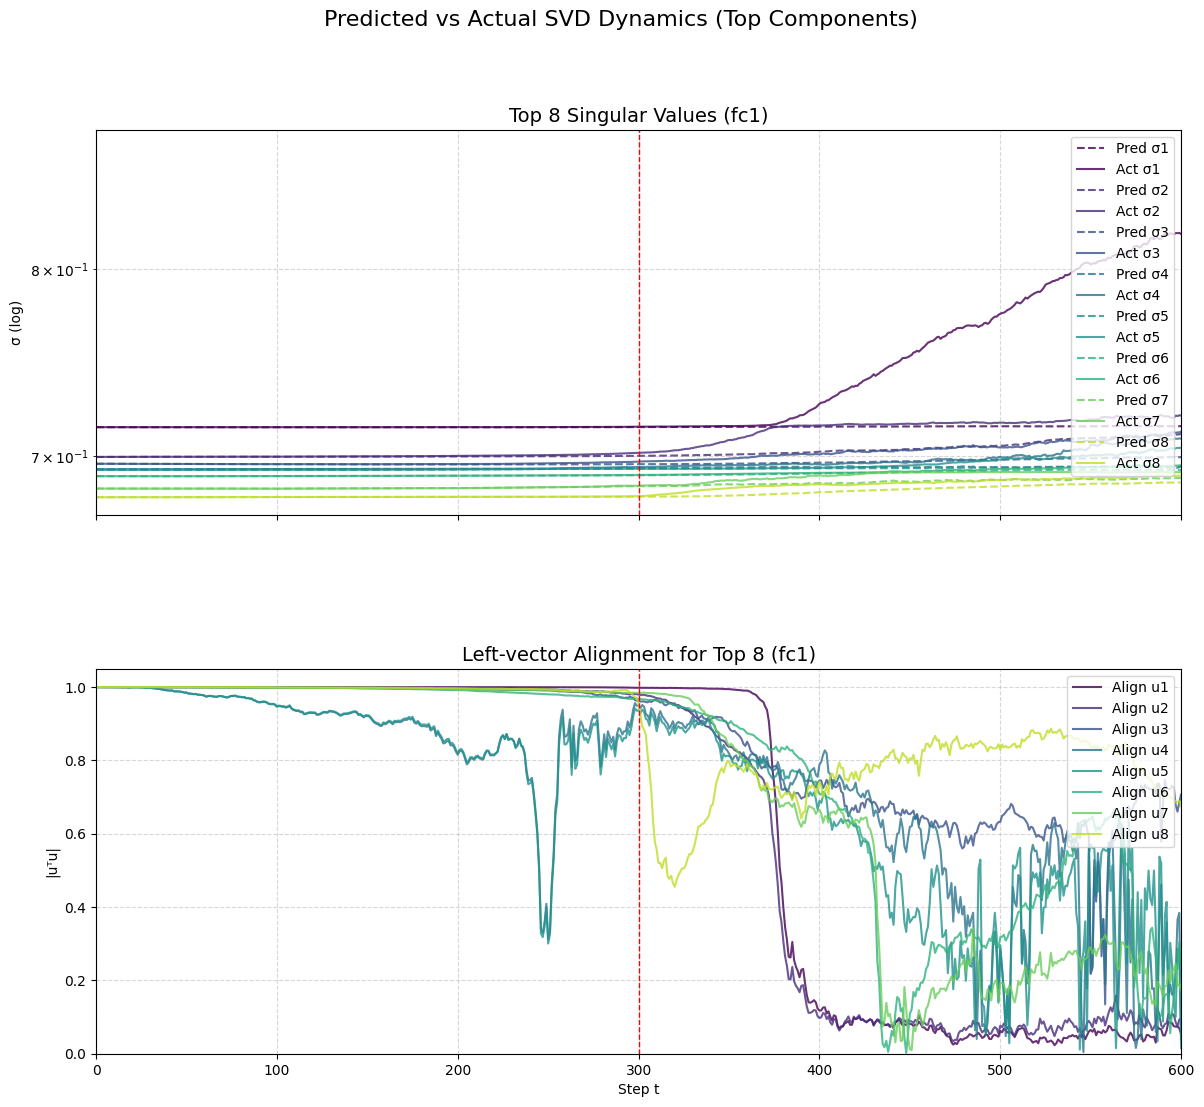

In [ ]:
plot_steps = min(len(S_hist)-1, len(S_act_hist))
steps = np.arange(plot_steps)
num_to_plot = min(k, 8)

S_pred_arr = np.array(S_hist[:plot_steps])
S_act_arr  = np.array(S_act_hist[:plot_steps])

# Compute alignments
align_arr = np.full((plot_steps, k), np.nan)
for t in range(plot_steps):
    for i in range(k):
        up, ua = U_hist[t][:,i], U_act_hist[t][:,i]
        if not np.all(np.isnan(up)) and not np.all(np.isnan(ua)):
            align_arr[t,i] = abs(np.dot(up, ua))

fig, axes = plt.subplots(2, 1, figsize=(14,12), sharex=True)

# --------- Top: Singular Values ----------
cmap = plt.cm.viridis(np.linspace(0,0.9,num_to_plot))
ax1 = axes[0]
for idx in range(num_to_plot):
    if np.any(~np.isnan(S_pred_arr[:,idx])):
        ax1.plot(steps, S_pred_arr[:,idx], '--', color=cmap[idx],
                 label=f"Pred σ{idx+1}", alpha=0.8)
    if np.any(~np.isnan(S_act_arr[:,idx])):
        ax1.plot(steps, S_act_arr[:,idx], '-', color=cmap[idx],
                 label=f"Act σ{idx+1}", alpha=0.8)

ax1.set_yscale('log')
ax1.axvline(300, color='red', linestyle='--', linewidth=1)
ax1.set_xlim(0,600)
ax1.set_title(f"Top {num_to_plot} Singular Values ({target_layer_name})", fontsize=14)
ax1.set_ylabel("σ (log)")
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, which='both', ls='--', alpha=0.5)

# ------ Bottom: Vector Alignment ------
ax2 = axes[1]
for idx in range(num_to_plot):
    if np.any(~np.isnan(align_arr[:,idx])):
        ax2.plot(steps, align_arr[:,idx], color=cmap[idx],
                 label=f"Align u{idx+1}", alpha=0.8)

ax2.axvline(300, color='red', linestyle='--', linewidth=1)
ax2.set_xlim(0,600)
ax2.set_ylim(0,1.05)
ax2.set_title(f"Left-vector Alignment for Top {num_to_plot} ({target_layer_name})", fontsize=14)
ax2.set_xlabel("Step t")
ax2.set_ylabel("|uᵀu|")
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, which='both', ls='--', alpha=0.5)

fig.suptitle("Predicted vs Actual SVD Dynamics (Top Components)", fontsize=16, y=0.98)
fig.subplots_adjust(top=0.88, hspace=0.4)

plt.show()


# Neural Network Spectral Analysis: Singular Value Tail Dynamics

## What This Does

Track singular values of neural network weight matrices during training and detect peaks in the **tail region** (beyond the bulk distribution). Fit **Equation 13** theoretical curves to explain these peaks.

## Key Idea

- **Bulk**: Most singular values follow random matrix predictions
- **Tail**: Values beyond Tracy-Widom edge may show structured peaks
- **Theory**: Equation 13 models these peaks using drift (D) and noise (β) parameters

## Equation 13
p_σ(σ) = 2 × (β/4ηD)^((m-n+3)/4) × σ^((m-n+3)/2-1) / Γ((m-n+3)/4) × exp(-(β/4ηD)σ²)

May take longer than 3 hours to run due to need for significant ensembling N = 1024


In [ ]:
# Install required packages
!pip install torch torchvision scikit-learn matplotlib numpy scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.special import gamma
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[1024, 1024, 1024], num_classes=10):
        super(SimpleMLP, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights with Gaussian N(0, 1/fan_in)
        for module in self.modules():
            if isinstance(module, nn.Linear):
                fan_in = module.weight.size(1)
                std = 1.0 / math.sqrt(fan_in)
                nn.init.normal_(module.weight, mean=0.0, std=std)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.network(x)

    def get_target_layers(self):
        """Return the linear layers for analysis"""
        target_layers = {}
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                target_layers[name] = module
        return target_layers

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"Loaded MNIST dataset with {len(train_dataset)} training samples")

Loaded MNIST dataset with 60000 training samples


In [ ]:
def compute_singular_values(weight_matrix):
    """Compute singular values of a weight matrix"""
    if weight_matrix.dim() == 2:
        matrix = weight_matrix.detach().cpu().numpy()
    else:
        matrix = weight_matrix.view(weight_matrix.size(0), -1).detach().cpu().numpy()

    # Center and normalize the matrix
    matrix_centered = matrix - np.mean(matrix, axis=1, keepdims=True)
    matrix_std = np.std(matrix_centered)
    if matrix_std > 0:
        matrix_normalized = matrix_centered / matrix_std
        # Additional normalization by sqrt(max dimension)
        max_dim = max(matrix_normalized.shape)
        matrix_normalized = matrix_normalized / np.sqrt(max_dim)
    else:
        matrix_normalized = matrix_centered

    # Compute SVD
    try:
        _, singular_values, _ = np.linalg.svd(matrix_normalized, full_matrices=False)
        return singular_values
    except np.linalg.LinAlgError:
        print("SVD failed, returning empty array")
        return np.array([])

def compute_loss_gradient_magnitude(model, data_loader, criterion, device):
    """Compute the magnitude of the loss gradient"""
    model.eval()

    data_iter = iter(data_loader)
    inputs, targets = next(data_iter)
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs.view(inputs.size(0), -1))
    loss = criterion(outputs, targets)

    model.zero_grad()
    loss.backward()

    total_grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_grad_norm += param_norm.item() ** 2

    total_grad_norm = total_grad_norm ** 0.5
    model.train()

    return total_grad_norm

In [ ]:
def compute_theoretical_distribution_eq13(sigma_values, eta, m, n, D, beta):
    """
    Compute theoretical distribution using formula 13:
    p_σ(σ) = 2 * (β/(4ηD))^((m-n+3)/4) * σ^((m-n+3)/2 - 1) / Γ((m-n+3)/4) * exp(-(β/(4ηD)) σ²)
    """
    if D <= 0 or beta <= 0:
        print(f"Warning: Invalid parameters for eq13: D={D}, beta={beta}")
        return np.zeros_like(sigma_values)

    # Formula 13 parameters
    exponent = (m - n + 3) / 4
    power_term = (m - n + 3) / 2 - 1

    # Scale factor from eq13
    scale_factor = beta / (4 * eta * D)

    if exponent <= 0:
        print(f"Warning: Invalid exponent {exponent:.3f} for dimensions m={m}, n={n}")
        return np.zeros_like(sigma_values)

    # Compute the distribution
    try:
        normalization = 2 * (scale_factor ** exponent) / gamma(exponent)
    except (ValueError, OverflowError) as e:
        print(f"Warning: Gamma function error for exponent {exponent:.3f}: {e}")
        return np.zeros_like(sigma_values)

    # Handle potential numerical issues
    sigma_values = np.maximum(sigma_values, 1e-12)

    # Compute PDF with numerical stability
    try:
        log_pdf = (np.log(normalization) +
                  power_term * np.log(sigma_values) -
                  scale_factor * sigma_values**2)
        pdf_values = np.exp(log_pdf)
    except (OverflowError, RuntimeWarning):
        pdf_values = normalization * (sigma_values ** power_term) * np.exp(-scale_factor * sigma_values**2)

    # Handle any NaN or inf values
    pdf_values = np.nan_to_num(pdf_values, nan=0.0, posinf=0.0, neginf=0.0)

    return pdf_values

In [ ]:
def plot_tail_with_peaks_and_theory(singular_values, loss_gradient, batch_num, layer_name,
                                   layer_shape, learning_rate=0.01, sv_min=2.0, sv_max=6.5):
    """Plot full histogram and focused tail histogram with peak detection and theoretical curves"""

    # Filter singular values to the specified range for tail analysis
    mask = (singular_values >= sv_min) & (singular_values <= sv_max)
    tail_values = singular_values[mask]

    print(f"Total singular values: {len(singular_values)}")
    print(f"Singular values in range [{sv_min}, {sv_max}]: {len(tail_values)}")
    print(f"Full SV range: [{np.min(singular_values):.3f}, {np.max(singular_values):.3f}]")

    # =============================================================================
    # PLOT 1: FULL HISTOGRAM
    # =============================================================================
    fig1, ax1 = plt.subplots(figsize=(12, 8))

    # Full histogram
    full_bins = max(min(len(singular_values) // 20, 150), 50)
    counts_full, bin_edges_full, patches_full = ax1.hist(singular_values, bins=full_bins,
                                                        density=False, alpha=0.7,
                                                        color='lightblue',
                                                        label='Full Singular Value Distribution')

    # Highlight the tail region we'll analyze
    ax1.axvspan(sv_min, sv_max, alpha=0.2, color='red',
               label=f'Tail Analysis Region [{sv_min}, {sv_max}]')
    ax1.axvline(x=sv_min, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax1.axvline(x=sv_max, color='red', linestyle='--', alpha=0.8, linewidth=2)

    # Add bulk edge marker (approximate)
    bulk_edge = 2.0
    ax1.axvline(x=bulk_edge, color='black', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Approximate Bulk Edge = {bulk_edge}')

    # Styling for full plot
    ax1.set_xlabel("Singular Value (σ)", fontsize=14)
    ax1.set_ylabel("Count", fontsize=14)
    ax1.set_title(f"Complete Singular Value Distribution\n{layer_name} - Batch {batch_num}", fontsize=16)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add statistics for full distribution
    full_stats_text = f"Total values: {len(singular_values)}\n"
    full_stats_text += f"Mean: {np.mean(singular_values):.3f}\n"
    full_stats_text += f"Std: {np.std(singular_values):.3f}\n"
    full_stats_text += f"Max: {np.max(singular_values):.3f}\n"
    full_stats_text += f"Median: {np.median(singular_values):.3f}"

    ax1.text(0.75, 0.98, full_stats_text, transform=ax1.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # PLOT 2: TAIL-ONLY ANALYSIS WITH PEAK DETECTION
    # =============================================================================

    if len(tail_values) == 0:
        print(f"No singular values in range [{sv_min}, {sv_max}] for detailed analysis")
        return 0

    # Create focused tail histogram
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    tail_bins = max(min(len(tail_values) // 5, 100), 20)
    counts, bin_edges, patches = ax2.hist(tail_values, bins=tail_bins, density=False,
                                       alpha=0.7, color='royalblue',
                                       label=f'Tail Histogram (σ ∈ [{sv_min}, {sv_max}])')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Peak detection with adjusted parameters for the specified range
    min_peak_height = np.max(counts) * 0.05  # Lower threshold for better detection
    min_distance = max(1, len(counts) // 30)  # Closer peaks allowed
    peaks, peak_properties = find_peaks(counts,
                                       height=min_peak_height,
                                       distance=min_distance,
                                       prominence=np.max(counts) * 0.02)  # Lower prominence threshold

    # Plot detected peaks
    if len(peaks) > 0:
        peak_positions = bin_centers[peaks]
        peak_heights = counts[peaks]

        # Mark peaks with red dots
        ax2.scatter(peak_positions, peak_heights,
                  color='red', s=150, zorder=5,
                  label=f'Detected Peaks ({len(peaks)})', edgecolors='black', linewidth=1)

        # Add vertical lines at peak positions
        for i, (pos, height) in enumerate(zip(peak_positions, peak_heights)):
            ax2.axvline(x=pos, color='red', linestyle='--', alpha=0.6, linewidth=1)
            # Annotate peak with its position
            ax2.annotate(f'Peak {i+1}\nσ={pos:.3f}',
                       xy=(pos, height),
                       xytext=(10, 15),
                       textcoords='offset points',
                       fontsize=10,
                       bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='yellow', alpha=0.8),
                       arrowprops=dict(arrowstyle='->',
                                     connectionstyle='arc3,rad=0.1'))

        # Add theoretical curves for each peak
        if layer_shape is not None:
            m, n = layer_shape

            # Compute D (drift): square of (max_sv - median_sv) divided by batch number
            max_sv = np.max(singular_values)  # Use full singular value array for D calculation
            median_sv = np.median(singular_values)
            batch_num_for_drift = max(1, batch_num)
            D = ((max_sv - median_sv) ** 2) / batch_num_for_drift

            # Use loss gradient as beta
            beta = loss_gradient if loss_gradient > 0 else 1.0

            print(f"\nTheoretical Parameters for {layer_name} batch {batch_num}:")
            print(f"  Matrix dimensions: {m} × {n}")
            print(f"  D (drift) = {D:.6f}")
            print(f"  β (loss grad) = {beta:.6f}")
            print(f"  Learning rate η = {learning_rate}")
            print(f"  Detected peaks at: {[f'{pos:.3f}' for pos in peak_positions]}")

            # Plot theoretical curve for each peak
            colors = ['green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'olive', 'navy']
            for i, (peak_pos, peak_height) in enumerate(zip(peak_positions, peak_heights)):
                # Create sigma range around the peak, constrained to our analysis range
                curve_width = (sv_max - sv_min) * 0.3  # Use 30% of total range around each peak

                sigma_start = max(sv_min, peak_pos - curve_width)
                sigma_end = min(sv_max, peak_pos + curve_width)
                sigma_range = np.linspace(sigma_start, sigma_end, 500)

                # Compute theoretical distribution
                theoretical_pdf = compute_theoretical_distribution_eq13(sigma_range, learning_rate, m, n, D, beta)

                if np.max(theoretical_pdf) > 0:
                    # Find theoretical peak and shift to match detected peak
                    theoretical_peak_idx = np.argmax(theoretical_pdf)
                    theoretical_peak_pos = sigma_range[theoretical_peak_idx]
                    shift_amount = peak_pos - theoretical_peak_pos
                    shifted_sigma = sigma_range + shift_amount

                    # Scale to match peak height
                    scale_factor = peak_height / np.max(theoretical_pdf)
                    scaled_pdf = theoretical_pdf * scale_factor

                    # Only plot points within our analysis range
                    visible_mask = (shifted_sigma >= sv_min) & (shifted_sigma <= sv_max)
                    if np.any(visible_mask):
                        color = colors[i % len(colors)]
                        ax2.plot(shifted_sigma[visible_mask], scaled_pdf[visible_mask],
                               '-.', linewidth=3, alpha=0.9,
                               label=f'Eq13 Peak {i+1} (D={D:.2e}, β={beta:.2e})',
                               color=color)

                        print(f" Plotted Eq13 curve for peak {i+1}: center σ={peak_pos:.3f}, shift={shift_amount:.3f}")
                else:
                    print(f" Warning: Zero theoretical distribution for peak {i+1}")
    else:
        print(f"  No significant peaks detected in range [{sv_min}, {sv_max}]")

    # Styling for tail plot
    ax2.set_xlabel(f"Singular Value (σ ∈ [{sv_min}, {sv_max}])", fontsize=14)
    ax2.set_ylabel("Count", fontsize=14)
    ax2.set_title(f"Tail Analysis with Equation 13 Theory\n{layer_name} - Batch {batch_num}", fontsize=16)
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Set x-axis limits to our analysis range
    ax2.set_xlim(sv_min, sv_max)

    # Add detailed statistics text box for tail region
    if len(tail_values) > 0:
        tail_stats_text = f"Tail Analysis Range: [{sv_min}, {sv_max}]\n"
        tail_stats_text += f"Values in range: {len(tail_values)}\n"
        tail_stats_text += f"% of total: {100*len(tail_values)/len(singular_values):.1f}%\n"
        tail_stats_text += f"Mean: {np.mean(tail_values):.3f}\n"
        tail_stats_text += f"Std: {np.std(tail_values):.3f}\n"
        tail_stats_text += f"Max: {np.max(tail_values):.3f}"

        ax2.text(0.02, 0.98, tail_stats_text, transform=ax2.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))

    plt.tight_layout()
    plt.show()

    return len(peaks) if len(peaks) > 0 else 0

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensembling parameters
num_ensemble_models = 1024
analysis_batches = [200, 400, 800]  # Analyze at these specific batches
total_batches = 1000  # Train each model for 1000 batches
target_layer_name = 'network.0'  # First linear layer

print("="*80)
print("ENSEMBLE TRAINING SETUP")
print("="*80)
print(f"Number of ensemble models: {num_ensemble_models}")
print(f"Analysis batches: {analysis_batches}")
print(f"Training batches per model: {total_batches}")
print(f"Target layer: {target_layer_name}")
print(f"Device: {device}")
print("="*80)

# Storage for ensemble results
ensemble_results = {
    'batch_numbers': analysis_batches,
    'loss_values': {batch: [] for batch in analysis_batches},  # Store losses from all models
    'loss_gradients': {batch: [] for batch in analysis_batches},  # Store gradients from all models
    'singular_values_data': {batch: [] for batch in analysis_batches}  # Store SVs from all models
}

# Get layer shape from a temporary model
temp_model = SimpleMLP().to(device)
target_layers = temp_model.get_target_layers()
if target_layer_name not in target_layers:
    print(f"Available layers: {list(target_layers.keys())}")
    target_layer_name = list(target_layers.keys())[0]
    print(f"Using layer: {target_layer_name}")

target_layer = target_layers[target_layer_name]
layer_shape = (target_layer.weight.size(0), target_layer.weight.size(1))
print(f"🔍 Target layer shape: {layer_shape}")
del temp_model  # Clean up

Using device: cuda
🎯 ENSEMBLE TRAINING SETUP
🔢 Number of ensemble models: 1
📊 Analysis batches: [200, 400, 800]
🚂 Training batches per model: 1000
🎯 Target layer: network.0
💻 Device: cuda
🔍 Target layer shape: (1024, 784)


In [ ]:
import time

print("STARTING ENSEMBLE TRAINING")
print("="*80)

start_time = time.time()

for ensemble_idx in range(num_ensemble_models):
    progress_pct = (ensemble_idx / num_ensemble_models) * 100
    print(f"\nTraining Model {ensemble_idx + 1:4d}/{num_ensemble_models} ({progress_pct:5.1f}%)")

    torch.manual_seed(42 + ensemble_idx)
    np.random.seed(42 + ensemble_idx)

    model = SimpleMLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9)

    # Get target layer for this model
    target_layers = model.get_target_layers()
    target_layer = target_layers[target_layer_name]

    # Create fresh data iterator for this model
    data_iter = iter(train_loader)
    batch_count = 0

    # Training loop for this model
    for batch_idx in range(total_batches):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            # Reset iterator when we finish an epoch
            data_iter = iter(train_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(inputs.size(0), -1)  # Flatten for MLP

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Analysis at specific batches
        if batch_count in analysis_batches:
            # Compute loss gradient magnitude
            loss_grad_magnitude = compute_loss_gradient_magnitude(model, train_loader, criterion, device)

            # Compute singular values for target layer
            with torch.no_grad():
                singular_values = compute_singular_values(target_layer.weight)

            # Store results for this model
            ensemble_results['loss_values'][batch_count].append(loss.item())
            ensemble_results['loss_gradients'][batch_count].append(loss_grad_magnitude)
            ensemble_results['singular_values_data'][batch_count].append(singular_values)

            # Brief progress update for analysis batches
            if ensemble_idx % 100 == 0:  # Print details every 100 models
                print(f" Batch {batch_count}: Loss={loss.item():.4f}, "
                      f"Grad={loss_grad_magnitude:.4f}, SVs={len(singular_values)}")

        batch_count += 1

    # Progress update every 50 models
    if (ensemble_idx + 1) % 50 == 0:
        elapsed = time.time() - start_time
        models_per_sec = (ensemble_idx + 1) / elapsed
        eta_minutes = (num_ensemble_models - ensemble_idx - 1) / models_per_sec / 60
        print(f"  Completed {ensemble_idx + 1} models | "
              f"Rate: {models_per_sec:.1f} models/sec | "
              f"ETA: {eta_minutes:.1f} min")

total_time = time.time() - start_time
print(f"\n ENSEMBLE TRAINING COMPLETED!")
print(f"Total training time: {total_time/60:.1f} minutes")
print(f"Models trained: {num_ensemble_models}")
print(f"Analysis batches: {analysis_batches}")

# Print ensemble data summary
print(f"\nENSEMBLE DATA SUMMARY:")
for batch_num in analysis_batches:
    num_models = len(ensemble_results['loss_values'][batch_num])
    total_sv_count = sum(len(svs) for svs in ensemble_results['singular_values_data'][batch_num])
    print(f"  Batch {batch_num}: {num_models} models, {total_sv_count:,} total singular values")

🚀 STARTING ENSEMBLE TRAINING

🤖 Training Model    1/1 (  0.0%)
    📊 Batch 200: Loss=0.1456, Grad=1.1232, SVs=784
    📊 Batch 400: Loss=0.4359, Grad=1.5567, SVs=784
    📊 Batch 800: Loss=0.2268, Grad=0.8109, SVs=784

🎉 ENSEMBLE TRAINING COMPLETED!
⏱️  Total training time: 0.3 minutes
🤖 Models trained: 1
📊 Analysis batches: [200, 400, 800]

📈 ENSEMBLE DATA SUMMARY:
  Batch 200: 1 models, 784 total singular values
  Batch 400: 1 models, 784 total singular values
  Batch 800: 1 models, 784 total singular values



🎯 ENSEMBLE ANALYSIS VISUALIZATION

📊 ENSEMBLE BATCH 200 ANALYSIS
📈 Mean loss across ensemble: 0.145618 ± 0.000000

🔍 ENSEMBLE ANALYSIS - BATCH 200
📊 Models in ensemble: 1
🔢 Total aggregated singular values: 784
📈 Mean loss gradient: 1.123240
📉 Loss gradient std: 0.000000
🎯 Values in range [2.0, 6.5]: 16
📊 Coverage: 2.04% of total


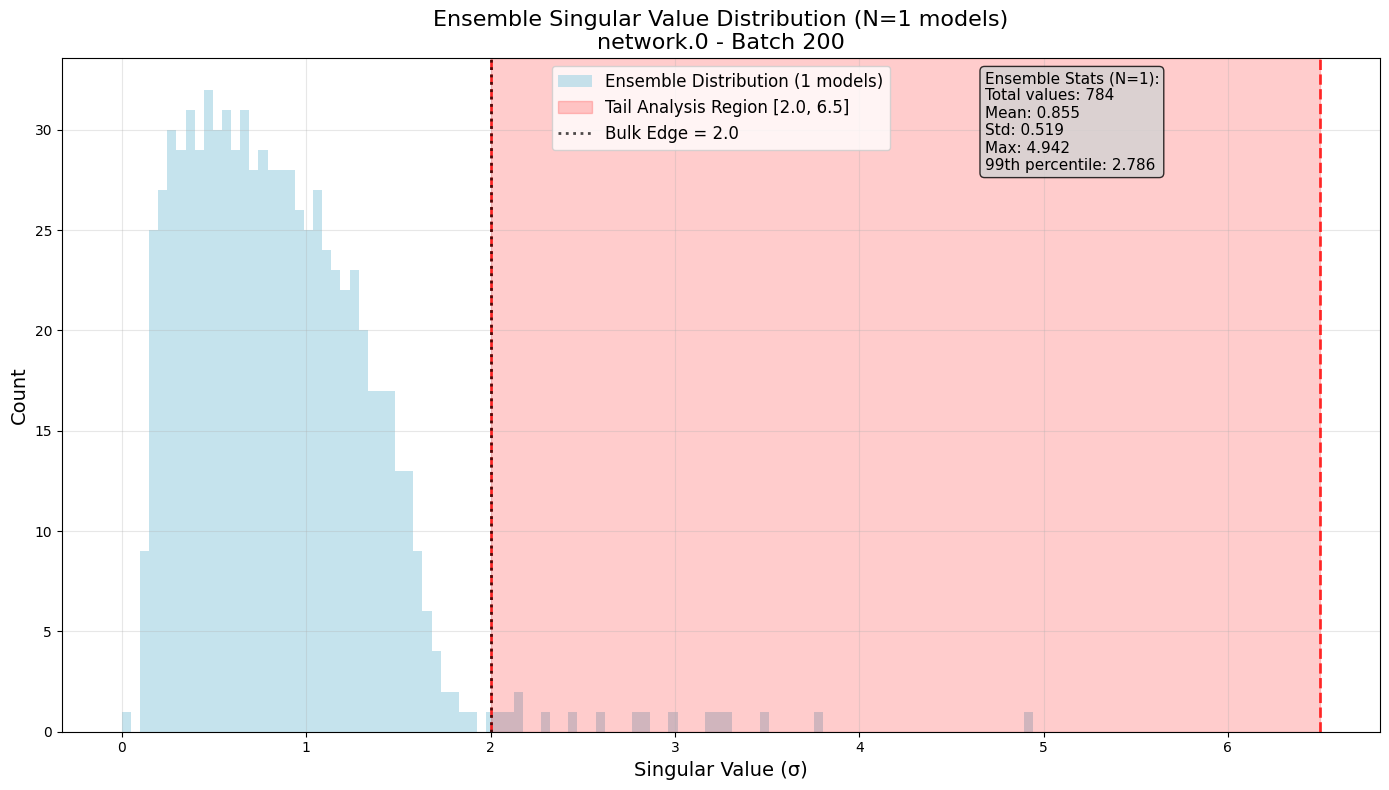

🎯 Peak detection: Found 6 peaks
🧮 Theoretical parameters:
  Matrix dimensions: 1024 × 784
  D (ensemble drift): 0.086073
  β (mean loss grad): 1.123240
  Peak positions: ['2.595', '2.786', '2.978', '3.265', '3.457', '3.744']


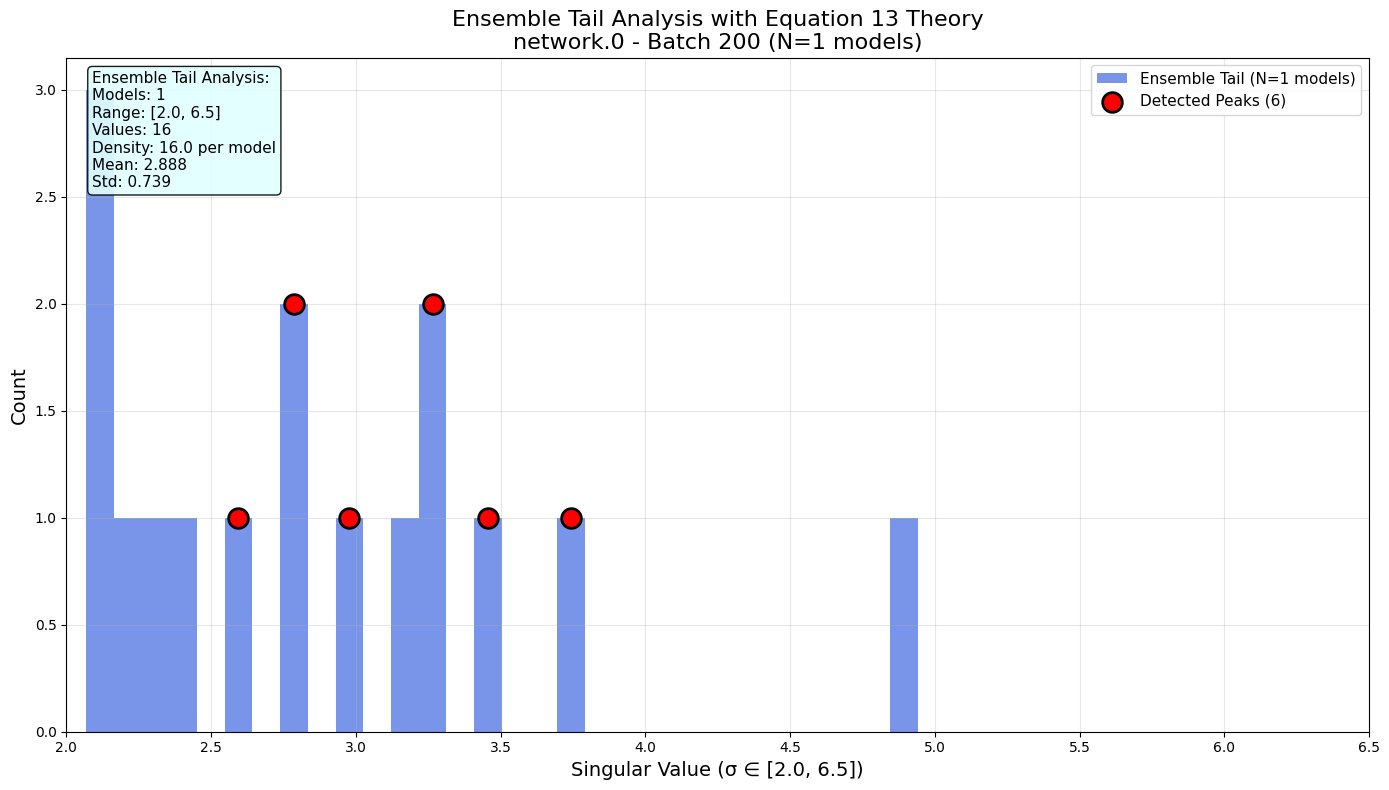

✅ Batch 200 complete: 6 peaks detected

📊 ENSEMBLE BATCH 400 ANALYSIS
📈 Mean loss across ensemble: 0.435931 ± 0.000000

🔍 ENSEMBLE ANALYSIS - BATCH 400
📊 Models in ensemble: 1
🔢 Total aggregated singular values: 784
📈 Mean loss gradient: 1.556685
📉 Loss gradient std: 0.000000
🎯 Values in range [2.0, 6.5]: 19
📊 Coverage: 2.42% of total


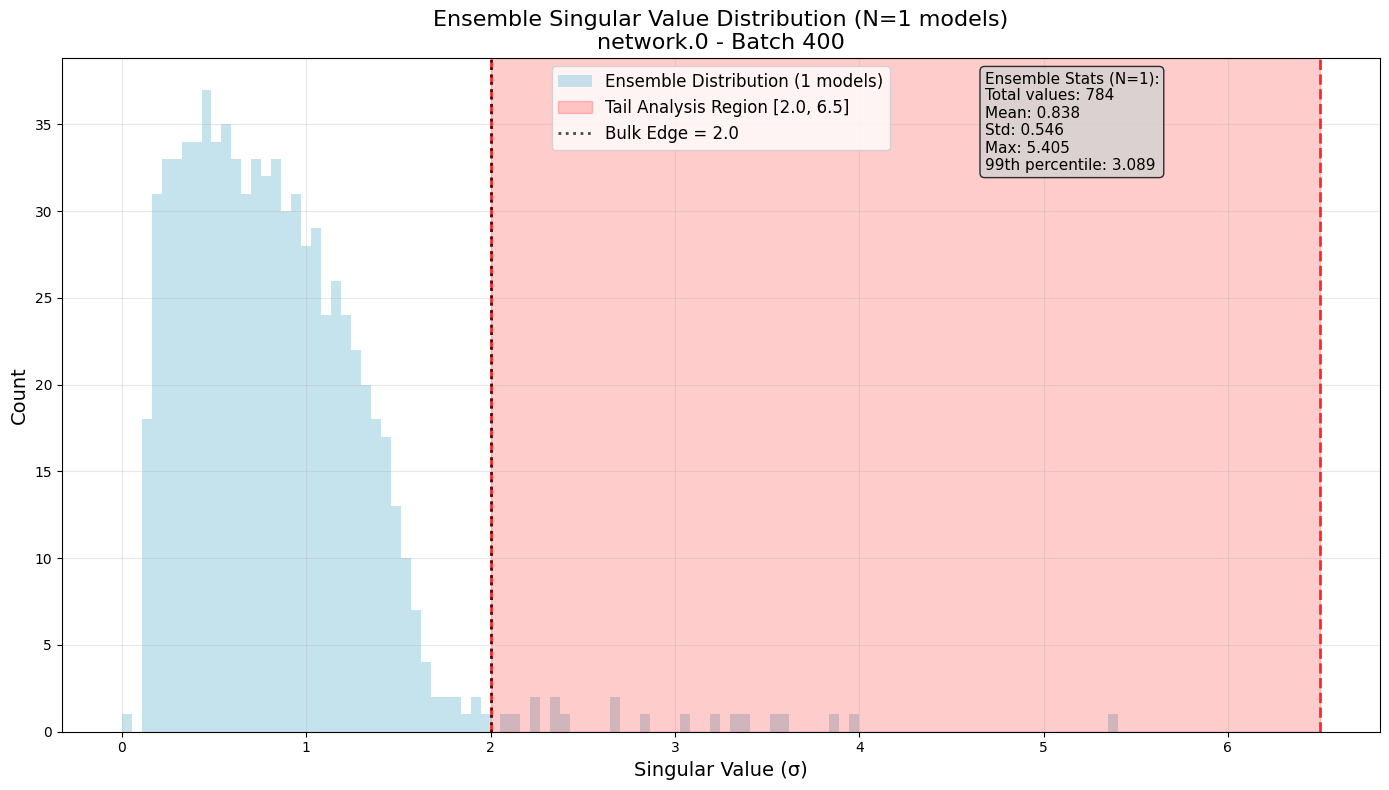

🎯 Peak detection: Found 6 peaks
🧮 Theoretical parameters:
  Matrix dimensions: 1024 × 784
  D (ensemble drift): 0.053856
  β (mean loss grad): 1.556685
  Peak positions: ['2.692', '2.913', '3.356', '3.578', '3.799', '4.021']


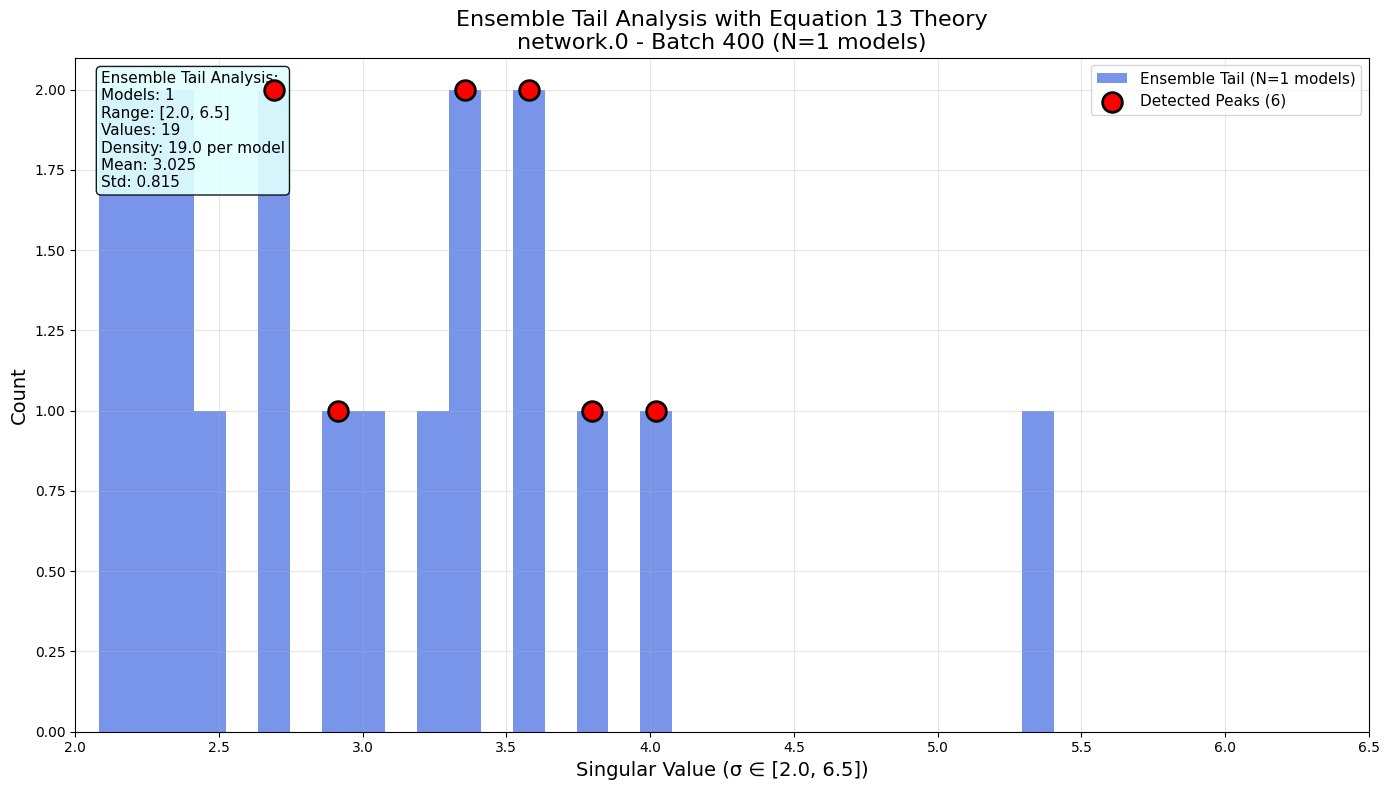

✅ Batch 400 complete: 6 peaks detected

📊 ENSEMBLE BATCH 800 ANALYSIS
📈 Mean loss across ensemble: 0.226771 ± 0.000000

🔍 ENSEMBLE ANALYSIS - BATCH 800
📊 Models in ensemble: 1
🔢 Total aggregated singular values: 784
📈 Mean loss gradient: 0.810938
📉 Loss gradient std: 0.000000
🎯 Values in range [2.0, 6.5]: 23
📊 Coverage: 2.93% of total


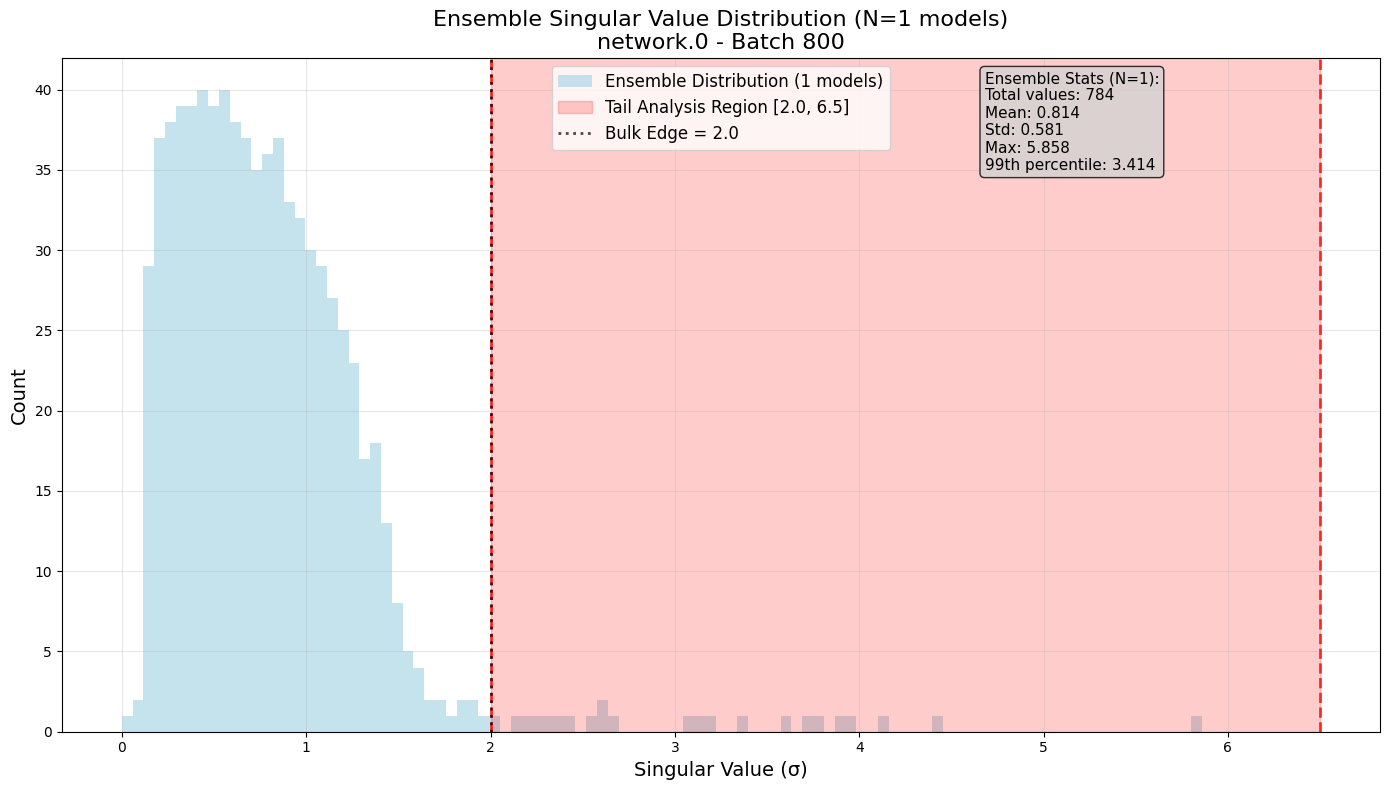

🎯 Peak detection: Found 5 peaks
🧮 Theoretical parameters:
  Matrix dimensions: 1024 × 784
  D (ensemble drift): 0.032960
  β (mean loss grad): 0.810938
  Peak positions: ['2.194', '2.580', '3.094', '3.737', '4.380']


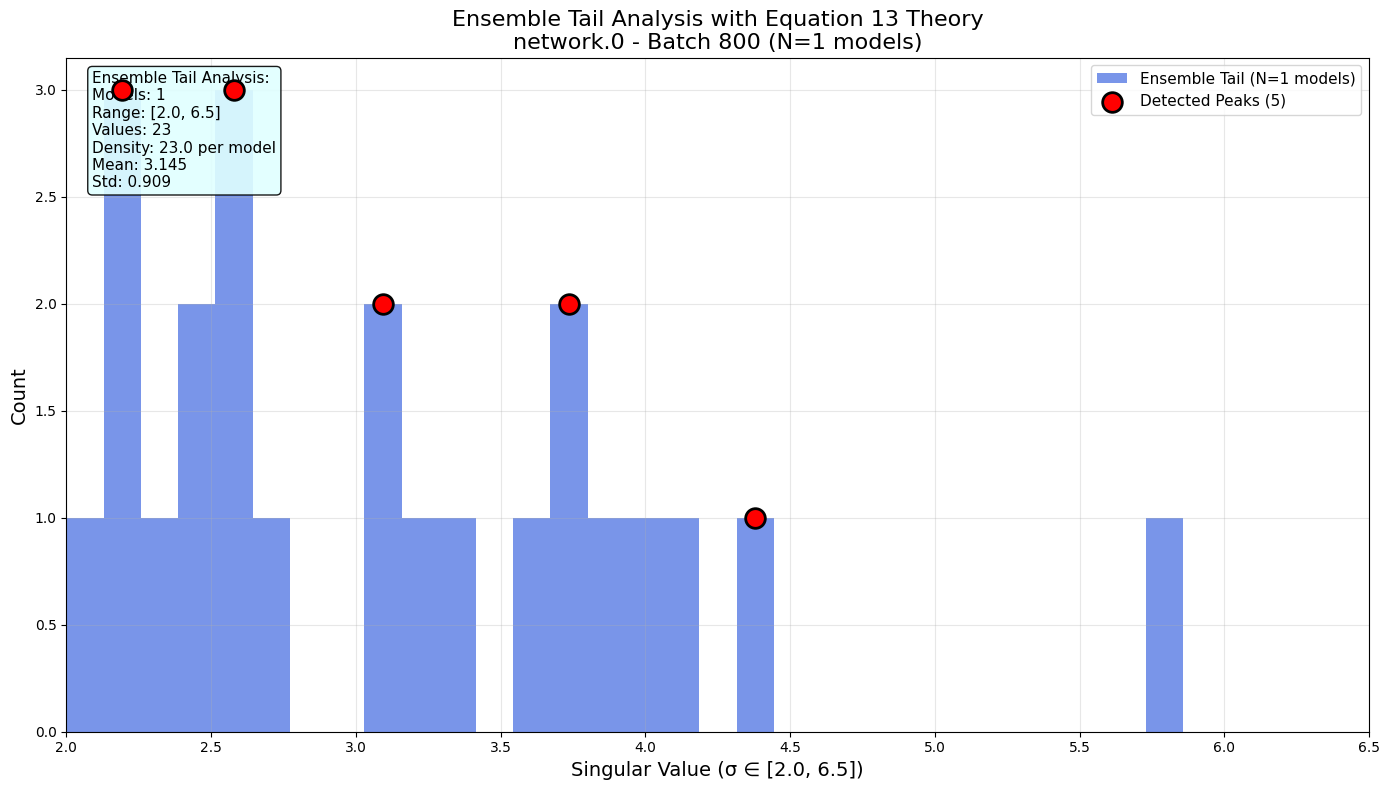

✅ Batch 800 complete: 5 peaks detected

🏆 FINAL ENSEMBLE SUMMARY
🤖 Ensemble size: 1 models
📊 Analysis batches: [200, 400, 800]
🎯 Total peaks across all batches: 17

📋 Detailed Summary by Batch:
  Batch 200: 6 peaks | 1 models | 784 SVs | Loss: 0.1456
  Batch 400: 6 peaks | 1 models | 784 SVs | Loss: 0.4359
  Batch 800: 5 peaks | 1 models | 784 SVs | Loss: 0.2268

🎉 Ensemble analysis complete! Statistical power: 1 models


In [ ]:
def plot_ensemble_tail_analysis(batch_num, ensemble_singular_values, ensemble_loss_gradients,
                               layer_name, layer_shape, learning_rate=0.01, sv_min=2.0, sv_max=6.5):
    """Plot ensemble analysis with aggregated data"""

    # Aggregate all singular values from ensemble
    all_singular_values = np.concatenate(ensemble_singular_values)

    # Use mean loss gradient across ensemble
    mean_loss_gradient = np.mean(ensemble_loss_gradients)

    print(f"\nENSEMBLE ANALYSIS - BATCH {batch_num}")
    print(f"Models in ensemble: {len(ensemble_singular_values)}")
    print(f"Total aggregated singular values: {len(all_singular_values):,}")
    print(f"Mean loss gradient: {mean_loss_gradient:.6f}")
    print(f"Loss gradient std: {np.std(ensemble_loss_gradients):.6f}")

    # Filter to analysis range
    mask = (all_singular_values >= sv_min) & (all_singular_values <= sv_max)
    tail_values = all_singular_values[mask]

    print(f"Values in range [{sv_min}, {sv_max}]: {len(tail_values):,}")
    print(f"Coverage: {100*len(tail_values)/len(all_singular_values):.2f}% of total")

    # =============================================================================
    # PLOT 1: FULL ENSEMBLE HISTOGRAM
    # =============================================================================
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    # Full histogram with more bins due to large dataset
    full_bins = max(min(len(all_singular_values) // 1000, 200), 100)
    counts_full, bin_edges_full, patches_full = ax1.hist(all_singular_values, bins=full_bins,
                                                        density=False, alpha=0.7,
                                                        color='lightblue',
                                                        label=f'Ensemble Distribution ({len(ensemble_singular_values)} models)')

    # Highlight the tail region
    ax1.axvspan(sv_min, sv_max, alpha=0.2, color='red',
               label=f'Tail Analysis Region [{sv_min}, {sv_max}]')
    ax1.axvline(x=sv_min, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax1.axvline(x=sv_max, color='red', linestyle='--', alpha=0.8, linewidth=2)

    # Add bulk edge marker
    bulk_edge = 2.0
    ax1.axvline(x=bulk_edge, color='black', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Bulk Edge = {bulk_edge}')

    # Styling
    ax1.set_xlabel("Singular Value (σ)", fontsize=14)
    ax1.set_ylabel("Count", fontsize=14)
    ax1.set_title(f"Ensemble Singular Value Distribution (N={len(ensemble_singular_values)} models)\n{layer_name} - Batch {batch_num}", fontsize=16)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Enhanced statistics
    ensemble_stats = f"Ensemble Stats (N={len(ensemble_singular_values)}):\n"
    ensemble_stats += f"Total values: {len(all_singular_values):,}\n"
    ensemble_stats += f"Mean: {np.mean(all_singular_values):.3f}\n"
    ensemble_stats += f"Std: {np.std(all_singular_values):.3f}\n"
    ensemble_stats += f"Max: {np.max(all_singular_values):.3f}\n"
    ensemble_stats += f"99th percentile: {np.percentile(all_singular_values, 99):.3f}"

    ax1.text(0.70, 0.98, ensemble_stats, transform=ax1.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # PLOT 2: ENSEMBLE TAIL ANALYSIS WITH PEAK DETECTION
    # =============================================================================

    if len(tail_values) == 0:
        print("No values in tail range for analysis")
        return 0

    fig2, ax2 = plt.subplots(figsize=(14, 8))

    # Tail histogram with more bins for ensemble data
    tail_bins = max(min(len(tail_values) // 50, 150), 30)
    counts, bin_edges, patches = ax2.hist(tail_values, bins=tail_bins, density=False,
                                       alpha=0.7, color='royalblue',
                                       label=f'Ensemble Tail (N={len(ensemble_singular_values)} models)')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Peak detection with adjusted parameters for ensemble data
    min_peak_height = np.max(counts) * 0.02  # Lower threshold for ensemble data
    min_distance = max(1, len(counts) // 50)
    peaks, peak_properties = find_peaks(counts,
                                       height=min_peak_height,
                                       distance=min_distance,
                                       prominence=np.max(counts) * 0.01)

    print(f"Peak detection: Found {len(peaks)} peaks")

    if len(peaks) > 0:
        peak_positions = bin_centers[peaks]
        peak_heights = counts[peaks]

        # Plot peaks
        ax2.scatter(peak_positions, peak_heights,
                  color='red', s=200, zorder=5,
                  label=f'Detected Peaks ({len(peaks)})',
                  edgecolors='black', linewidth=2)

        # Theoretical analysis
        if layer_shape is not None:
            m, n = layer_shape

            # Compute ensemble statistics for D and beta
            max_sv = np.max(all_singular_values)
            median_sv = np.median(all_singular_values)
            D = ((max_sv - median_sv) ** 2) / max(1, batch_num)
            beta = mean_loss_gradient

            print(f"Theoretical parameters:")
            print(f"  Matrix dimensions: {m} × {n}")
            print(f"  D (ensemble drift): {D:.6f}")
            print(f"  β (mean loss grad): {beta:.6f}")
            print(f"  Peak positions: {[f'{pos:.3f}' for pos in peak_positions]}")

            # Plot theoretical curves
            colors = ['green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'olive', 'navy']
            for i, (peak_pos, peak_height) in enumerate(zip(peak_positions, peak_heights)):
                curve_width = (sv_max - sv_min) * 0.2
                sigma_start = max(sv_min, peak_pos - curve_width)
                sigma_end = min(sv_max, peak_pos + curve_width)
                sigma_range = np.linspace(sigma_start, sigma_end, 500)

                theoretical_pdf = compute_theoretical_distribution_eq13(sigma_range, learning_rate, m, n, D, beta)

                if np.max(theoretical_pdf) > 0:
                    theoretical_peak_idx = np.argmax(theoretical_pdf)
                    theoretical_peak_pos = sigma_range[theoretical_peak_idx]
                    shift_amount = peak_pos - theoretical_peak_pos
                    shifted_sigma = sigma_range + shift_amount

                    scale_factor = peak_height / np.max(theoretical_pdf)
                    scaled_pdf = theoretical_pdf * scale_factor

                    visible_mask = (shifted_sigma >= sv_min) & (shifted_sigma <= sv_max)
                    if np.any(visible_mask):
                        color = colors[i % len(colors)]
                        ax2.plot(shifted_sigma[visible_mask], scaled_pdf[visible_mask],
                               '-.', linewidth=4, alpha=0.9,
                               label=f'Eq13 Peak {i+1} (D={D:.2e}, β={beta:.2e})',
                               color=color)

    # Styling
    ax2.set_xlabel(f"Singular Value (σ ∈ [{sv_min}, {sv_max}])", fontsize=14)
    ax2.set_ylabel("Count", fontsize=14)
    ax2.set_title(f"Ensemble Tail Analysis with Equation 13 Theory\n{layer_name} - Batch {batch_num} (N={len(ensemble_singular_values)} models)", fontsize=16)
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(sv_min, sv_max)

    # Enhanced tail statistics
    tail_stats = f"Ensemble Tail Analysis:\n"
    tail_stats += f"Models: {len(ensemble_singular_values)}\n"
    tail_stats += f"Range: [{sv_min}, {sv_max}]\n"
    tail_stats += f"Values: {len(tail_values):,}\n"
    tail_stats += f"Density: {len(tail_values)/len(ensemble_singular_values):.1f} per model\n"
    tail_stats += f"Mean: {np.mean(tail_values):.3f}\n"
    tail_stats += f"Std: {np.std(tail_values):.3f}"

    ax2.text(0.02, 0.98, tail_stats, transform=ax2.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))

    plt.tight_layout()
    plt.show()

    return len(peaks) if len(peaks) > 0 else 0

# Generate ensemble analysis plots
print("\n" + "="*80)
print("ENSEMBLE ANALYSIS VISUALIZATION")
print("="*80)

total_ensemble_peaks = 0
ensemble_summary = {}

for batch_num in analysis_batches:
    print(f"\n{'='*60}")
    print(f"ENSEMBLE BATCH {batch_num} ANALYSIS")
    print(f"{'='*60}")

    ensemble_svs = ensemble_results['singular_values_data'][batch_num]
    ensemble_grads = ensemble_results['loss_gradients'][batch_num]
    ensemble_losses = ensemble_results['loss_values'][batch_num]

    print(f"Mean loss across ensemble: {np.mean(ensemble_losses):.6f} ± {np.std(ensemble_losses):.6f}")

    num_peaks = plot_ensemble_tail_analysis(
        batch_num=batch_num,
        ensemble_singular_values=ensemble_svs,
        ensemble_loss_gradients=ensemble_grads,
        layer_name=target_layer_name,
        layer_shape=layer_shape,
        learning_rate=0.01,
        sv_min=2.0,
        sv_max=6.5
    )

    total_ensemble_peaks += num_peaks
    ensemble_summary[batch_num] = {
        'peaks': num_peaks,
        'models': len(ensemble_svs),
        'total_svs': sum(len(svs) for svs in ensemble_svs),
        'mean_loss': np.mean(ensemble_losses)
    }

    print(f"Batch {batch_num} complete: {num_peaks} peaks detected")

print(f"\n" + "="*80)
print("FINAL ENSEMBLE SUMMARY")
print("="*80)
print(f"Ensemble size: {num_ensemble_models} models")
print(f"Analysis batches: {analysis_batches}")
print(f"Total peaks across all batches: {total_ensemble_peaks}")

print(f"\nDetailed Summary by Batch:")
for batch_num, summary in ensemble_summary.items():
    print(f"  Batch {batch_num:3d}: {summary['peaks']} peaks | "
          f"{summary['models']} models | "
          f"{summary['total_svs']:,} SVs | "
          f"Loss: {summary['mean_loss']:.4f}")

print(f"\nEnsemble analysis complete! Statistical power: {num_ensemble_models:,} models")